# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

## Step 1. Install and import required packages.

In [1]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

Running in Colab.
Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 649 (delta 85), reused 129 (delta 75), pack-reused 503
Receiving objects: 100% (649/649), 2.42 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (345/345), done.
/content/ast
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=bf55848b9dafa97c4e5a74aaf1d400e61cd75ca1d088f00550662d20913f2eec
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper.

In [2]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

# Load the AudioSet label set
label_csv = '/content/ast/egs/audioset/data/class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction):

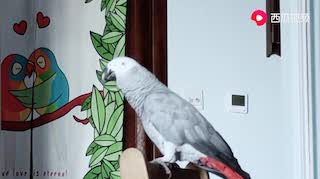

Replace the `sample_audio_path` to test your own audio.

In [3]:
# Get a sample audio and make feature for predict
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
sample_audio_path = 'https://www.dropbox.com/s/vddohcnb9ane9ag/LDoXsip0BEQ_000177.flac?dl=1'
#sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

if os.path.exists('/content/ast/sample_audios') == False:
  os.mkdir('/content/ast/sample_audios')
if os.path.exists('/content/ast/sample_audios/sample_audio.flac') == True:
  os.remove('/content/ast/sample_audios/sample_audio.flac')
wget.download(sample_audio_path, '/content/ast/sample_audios/sample_audio.flac')
feats = make_features('/content/ast/sample_audios/sample_audio.flac', mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio('/content/ast/sample_audios/sample_audio.flac')

Predice results:
- Domestic animals, pets: 0.5923
- Speech: 0.5825
- Bird: 0.3728
- Animal: 0.3386
- Dog: 0.2527
- Chirp, tweet: 0.0930
- Inside, small room: 0.0792
- Whistle: 0.0750
- Bird vocalization, bird call, bird song: 0.0676
- Squeak: 0.0487
Listen to this sample: 


## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

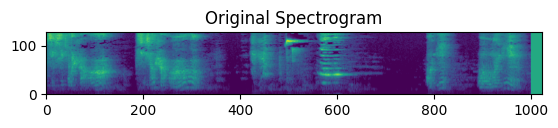

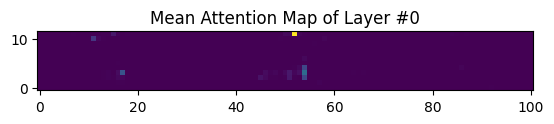

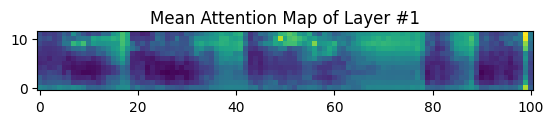

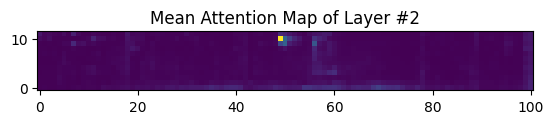

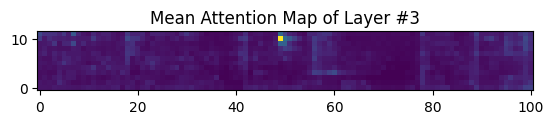

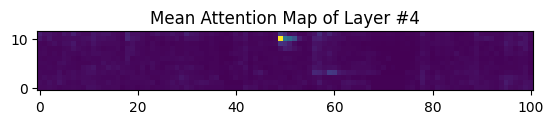

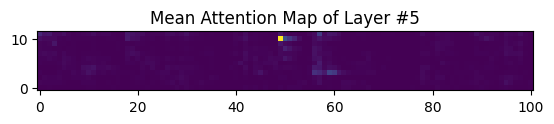

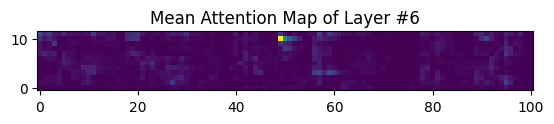

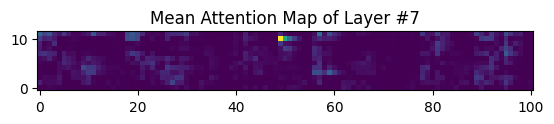

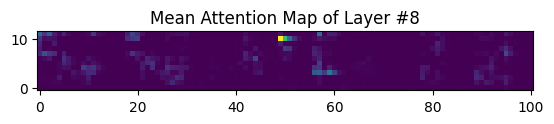

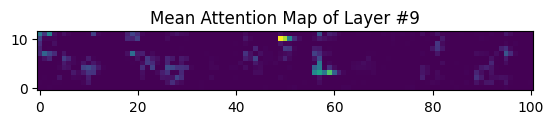

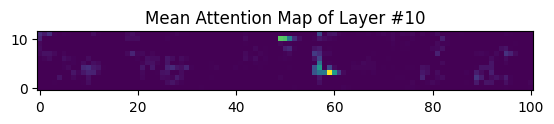

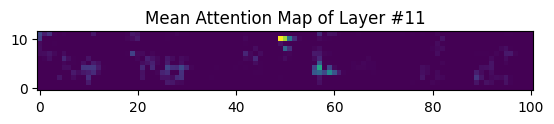

In [4]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

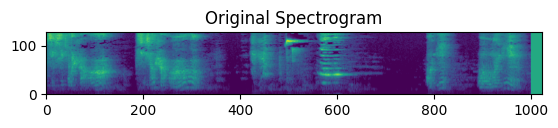

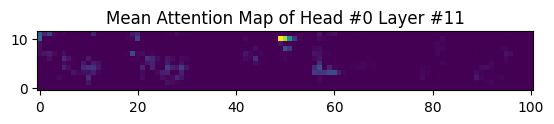

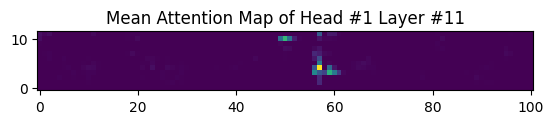

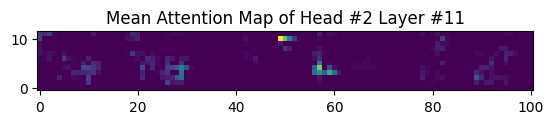

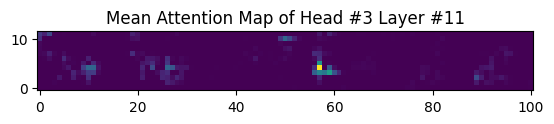

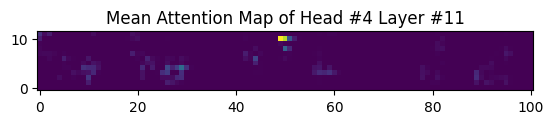

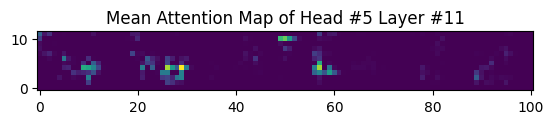

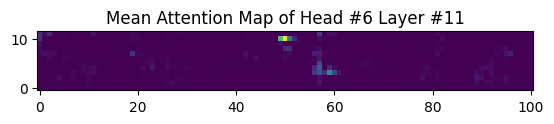

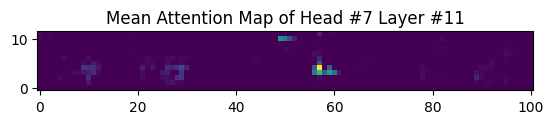

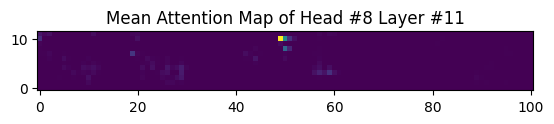

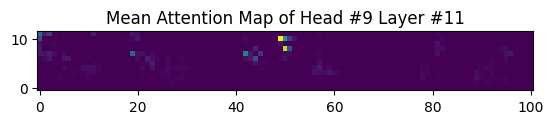

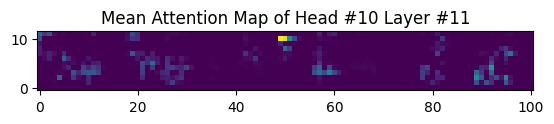

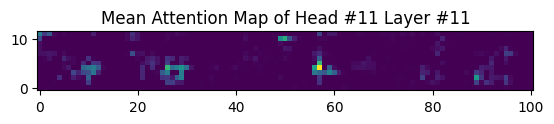

In [5]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()